# Let's try approach semantic analysis with fuzzy logic + ml

The goal of this study is to apply fuzzy logic and custom word vector embeddings to enhance emotion detection in textual analysis. 

We apply support vector machine technology to different vector embeddings to create custom vector embedding of words that would represent different types of moods. 

We then generate fuzzy logic rules to detect emotional state based on these moods. The proposed approach is to use evolutionary algorithms to receive best sets of logic rules that would apply for particular task. 

By instituting trapezoidal membership functions across a spectrum of emotional states and employing a robust set of fuzzy inference rules, the proposed approach yields a granular and context-sensitive interpretation of textual moods.

![nlp-ml](../images/nlp_fuzzy.png)

In [1]:
# imports section
import numpy as np
import math
from numpy import dot
from numpy.linalg import norm
from gensim import corpora, models, similarities
import string

import gensim.downloader as api
from gensim.models import Word2Vec
import itertools

In [ ]:
expected = {}
expected['lonely'] = [0.1, 0.5, 1, 0.6, 0.1, 0.0]

In [3]:
# Define the lexicon with mood vectors
moods = {0: "Angry", 1: "Worried", 2: "Sad", 3: "Calm", 4: "Happy", 5: "Excited"}
moods_indeces = {y.lower(): x for x, y in moods.items()}

lexicon = {
    # "frustrated": [0.8, 0.4, 0.3, 0, 0, 0], 
    "anxious": [0.3, 0.9, 0.4, 0, 0, 0.1], # "disappointed": [0.5, 0.3, 0.8, 0.1, 0, 0], 
    "furious": [0.9, 0.3, 0.2, 0, 0, 0], "peaceful": [0, 0, 0, 1, 0.4, 0.2], 
    "hate": [0.9, 0.3, 0.3, 0, 0, 0], "joyful": [0, 0, 0, 0.2, 0.9, 0.7], 
    "unacceptable": [0.9, 0.6, 0.6, 0, 0, 0], "thrilled": [0, 0, 0, 0, 0.6, 1], 
    "infuriating": [0.9, 0.8, 0.6, 0, 0, 0], "irate": [0.9, 0.2, 0.1, 0, 0, 0], 
    "terrible": [0.9, 0.7, 0.7, 0, 0, 0], "nervous": [0.2, 0.8, 0.3, 0.1, 0, 0.2],
    "melancholy": [0.1, 0.4, 0.9, 0.2, 0, 0], "depressed": [0.1, 0.1, 0.9, 0.2, 0, 0], 
    "gloomy": [0.1, 0.1, 0.8, 0.3, 0, 0], "serene": [0, 0, 0, 0.9, 0.8, 0.9], 
    "elated": [0, 0, 0, 0.1, 0.8, 0.9], "ecstatic": [0, 0, 0, 0, 0.7, 1],
    "overjoyed": [0.1, 0.1, 0.1, 0.1, 1, 0.9], "gleeful": [0.1, 0.1, 0.1, 0.1, 0.9, 0.8],
    "cheerful": [0.1, 0.1, 0.1, 0.1, 0.8, 0.5], "optimistic": [0.1, 0.2, 0.1, 0.7, 0.8, 0.6],
    "buoyant": [0.1, 0.2, 0.1, 0.8, 0.7, 0.7], "enthusiastic": [0.2, 0.3, 0.1, 0.6, 0.8, 0.9],
    "upbeat": [0.1, 0.2, 0.1, 0.7, 0.8, 0.7], "festive": [0.1, 0.1, 0.1, 0.7, 0.8, 0.7],
    "playful": [0.1, 0.2, 0.1, 0.6, 0.7, 0.8], "vivacious": [0.1, 0.2, 0.1, 0.6, 0.8, 0.7],
    "jovial": [0.1, 0.2, 0.1, 0.7, 0.8, 0.7], "amused": [0.1, 0.2, 0.1, 0.6, 0.7, 0.7],
    "blissful": [0.1, 0.1, 0.1, 0.8, 0.9, 0.7], "grateful": [0.1, 0.1, 0.1, 0.8, 0.9, 0.7],
    "tranquil": [0.1, 0.1, 0.1, 0.9, 0.8, 0.6], "relaxed": [0.1, 0.1, 0.1, 0.9, 0.8, 0.6],
    "comfortable": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6], "cozy": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6],
    "warm": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6], "inviting": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6], 
    "satisfied": [0.1, 0.1, 0.2, 0.6, 0.5, 0.3], "pleasant": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6], 
    "pleased" : [0.1, 0.1, 0.1, 0.9, 0.8, 0.3], "mellow": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6] , 
    "happy": [0.1, 0.1, 0.1, 0.7, 1, 0.6]
    }

In [4]:
corpus = api.load('glove-wiki-gigaword-100')

vector = corpus['computer']
print(vector)

[-1.6298e-01  3.0141e-01  5.7978e-01  6.6548e-02  4.5835e-01 -1.5329e-01
  4.3258e-01 -8.9215e-01  5.7747e-01  3.6375e-01  5.6524e-01 -5.6281e-01
  3.5659e-01 -3.6096e-01 -9.9662e-02  5.2753e-01  3.8839e-01  9.6185e-01
  1.8841e-01  3.0741e-01 -8.7842e-01 -3.2442e-01  1.1202e+00  7.5126e-02
  4.2661e-01 -6.0651e-01 -1.3893e-01  4.7862e-02 -4.5158e-01  9.3723e-02
  1.7463e-01  1.0962e+00 -1.0044e+00  6.3889e-02  3.8002e-01  2.1109e-01
 -6.6247e-01 -4.0736e-01  8.9442e-01 -6.0974e-01 -1.8577e-01 -1.9913e-01
 -6.9226e-01 -3.1806e-01 -7.8565e-01  2.3831e-01  1.2992e-01  8.7721e-02
  4.3205e-01 -2.2662e-01  3.1549e-01 -3.1748e-01 -2.4632e-03  1.6615e-01
  4.2358e-01 -1.8087e+00 -3.6699e-01  2.3949e-01  2.5458e+00  3.6111e-01
  3.9486e-02  4.8607e-01 -3.6974e-01  5.7282e-02 -4.9317e-01  2.2765e-01
  7.9966e-01  2.1428e-01  6.9811e-01  1.1262e+00 -1.3526e-01  7.1972e-01
 -9.9605e-04 -2.6842e-01 -8.3038e-01  2.1780e-01  3.4355e-01  3.7731e-01
 -4.0251e-01  3.3124e-01  1.2576e+00 -2.7196e-01 -8

In [5]:
print(corpus['computer'][0])

-0.16298


In [7]:
data = ''

with open('../resources/sets/english-adjectives.txt', 'r') as file:
    data = file.read().replace('\n', ',')

adjectives = data.split(',')
print(adjectives[:20])

['abandoned', 'able', 'absolute', 'adorable', 'adventurous', 'academic', 'acceptable', 'acclaimed', 'accomplished', 'accurate', 'aching', 'acidic', 'acrobatic', 'active', 'actual', 'adept', 'admirable', 'admired', 'adolescent', 'adorable']


In [8]:
adjectives_vectors = {}

for adjective in adjectives:
    adjectives_vectors[adjective] = corpus[adjective]

# print(adjectives_vectors)
for key, value in itertools.islice(adjectives_vectors.items(), 2):
    print(key, ":", value)

abandoned : [ 0.43756    0.22949   -0.24099    0.42471   -0.25692    0.073755
 -0.096612   0.46294    0.85405    0.30859    0.35545    0.81983
  0.20312   -0.1225     0.17376   -0.62581    0.48522    0.23915
 -0.24558   -0.11948    0.69671    0.57527    0.65548   -0.029388
 -0.19702   -0.4308    -0.77335   -0.5166    -0.201      0.48815
  0.23728    0.31009   -0.25274   -0.042121  -0.19871   -0.17874
  0.019558  -0.42301    0.0743    -0.073421  -0.57583   -0.30048
  0.64496   -0.071048   0.52107    0.17243   -0.13616    0.97539
  0.23503   -0.28925   -0.072434   0.10553    0.24934    0.82306
  0.21013   -1.7977    -0.54545   -0.29966    1.0294     0.16126
  0.081623   0.53188    0.20484    0.36831    0.7118    -0.23808
  0.16678   -0.16994   -0.56703   -0.22874   -0.042396  -0.0065193
  0.01364   -0.2084    -0.35861   -0.055815   0.16845    0.46759
 -0.9905     0.35124   -0.070496   0.20322   -0.20443    0.75299
 -0.70367    0.19664    0.045248  -0.044681  -0.95952    0.31755
 -0.11741

Using ML we can extend defined vectors to the whole space of words of interest.
ML - classification and regression;
Here we are going to apply some regression:
- Polynomial regression
- Support vector regression 
- Decision tree regression
- Random forest regression 
- 

Also we ca apply:
- Dimensionality reduction 
- Kohonen map
- 


Let's try applying polynomial regression to mapping adjactives to our vector space

In [9]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


# Define the degree of the polynomial features
degree = 3  # You can experiment with different degrees

# Create a pipeline that includes PolynomialFeatures and LinearRegression
model = Pipeline([
    ('poly', PolynomialFeatures(degree=degree)),
    ('linear', LinearRegression())
])

x_train, y_train = [], []
for key in lexicon.keys():
    x_train.append(adjectives_vectors[key])
    y_train.append(lexicon[key])

x_train_np = np.array(x_train)
y_train_np = np.array(y_train)

# Train the model
model.fit(x_train, y_train)

lexicon_trained = {}
for key in adjectives_vectors:
    result = model.predict([adjectives_vectors[key]])
    lexicon_trained[key] = result

for key, value in itertools.islice(lexicon_trained.items(), 10):
    print(key, ":", value)

abandoned : [[0.32317639 0.25339492 0.24257624 0.47616552 0.52784361 0.42721445]]
able : [[0.2992916  0.34903521 0.24096157 0.60392428 0.57864176 0.34701217]]
absolute : [[0.35318007 0.27168152 0.27121194 0.47428524 0.49266734 0.41936673]]
adorable : [[0.22084917 0.24326469 0.18947029 0.44065253 0.66891085 0.58757899]]
adventurous : [[0.22041089 0.25171863 0.17750381 0.51526528 0.62645102 0.62195696]]
academic : [[0.29220441 0.24158266 0.225727   0.52612072 0.56543346 0.47077341]]
acceptable : [[0.38258279 0.2767824  0.28608295 0.44254501 0.44166223 0.3503901 ]]
acclaimed : [[0.2972886  0.25117975 0.22408781 0.52039084 0.59370068 0.5127901 ]]
accomplished : [[0.27403816 0.22458991 0.19826061 0.52999849 0.60410334 0.52231761]]
accurate : [[0.29455266 0.24777829 0.22181902 0.50997164 0.56196879 0.47435633]]


Support vector regression:

In [10]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create a pipeline with StandardScaler and SVR, wrapped in MultiOutputRegressor
model = MultiOutputRegressor(make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0)))

x_train, y_train = [], []
for key in lexicon.keys():
    x_train.append(adjectives_vectors[key])
    y_train.append(lexicon[key])

x_train_np = np.array(x_train)
y_train_np = np.array(y_train)

# Train the model
model.fit(x_train, y_train)

lexicon_trained = {}
for key in adjectives_vectors:
    result = model.predict([adjectives_vectors[key]])
    lexicon_trained[key] = result

for key, value in itertools.islice(lexicon_trained.items(), 10):
    print(key, ":", value)

abandoned : [[0.36450785 0.27966769 0.31859443 0.50023933 0.4371489  0.34419666]]
able : [[0.3430226  0.32288296 0.28917978 0.54112484 0.47876259 0.35876806]]
absolute : [[0.37397818 0.29097715 0.32589258 0.5177005  0.44704643 0.35855004]]
adorable : [[0.28049398 0.26668014 0.27283056 0.41543006 0.58737366 0.48421475]]
adventurous : [[0.28793654 0.28654378 0.25081813 0.48273499 0.57142011 0.52699778]]
academic : [[0.35202655 0.27490655 0.31864453 0.53357321 0.45016868 0.37739466]]
acceptable : [[0.42209738 0.31427118 0.32262799 0.50984958 0.43412611 0.32382094]]
acclaimed : [[0.34911582 0.26365228 0.30469808 0.53400377 0.48816278 0.40375973]]
accomplished : [[0.30862104 0.2553403  0.25841672 0.55217642 0.56411535 0.47189207]]
accurate : [[0.35404155 0.27981558 0.30862057 0.53763056 0.46982867 0.38353912]]


SVR for one parameter:

In [12]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create a pipeline with StandardScaler and SVR, wrapped in MultiOutputRegressor
model = MultiOutputRegressor(make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0)))

x_train, y_train = [], []
for key in lexicon.keys():
    x_train.append(adjectives_vectors[key])
    y_train.append([lexicon[key][0], 0])

x_train_np = np.array(x_train)
y_train_np = np.array(y_train)

# Train the model
model.fit(x_train, y_train)

lexicon_trained = {}
for key in adjectives_vectors:
    result = model.predict([adjectives_vectors[key]])
    lexicon_trained[key] = result[0][0]

for key, value in itertools.islice(lexicon_trained.items(), 10):
    print(key, ":", value)

abandoned : 0.36450785095391314
able : 0.3430226031808837
absolute : 0.3739781823882929
adorable : 0.2804939785809792
adventurous : 0.28793654132037694
academic : 0.3520265512544812
acceptable : 0.4220973767652725
acclaimed : 0.3491158160135293
accomplished : 0.30862103813915764
accurate : 0.3540415527531092


SVR for each parameter separately:

In [14]:
lexicon_trained = {}
for key in adjectives_vectors:
    lexicon_trained[key] = [0, 0, 0, 0, 0, 0]

from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

for i in range(6):
    # Create a pipeline with StandardScaler and SVR, wrapped in MultiOutputRegressor
    model = MultiOutputRegressor(make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0)))

    x_train, y_train = [], []
    for key in lexicon.keys():
        x_train.append(adjectives_vectors[key])
        y_train.append([lexicon[key][i], 0])

    x_train_np = np.array(x_train)
    y_train_np = np.array(y_train)

    # Train the model
    model.fit(x_train, y_train)

    for key in adjectives_vectors:
        result = model.predict([adjectives_vectors[key]])
        lexicon_trained[key][i] = result[0][0]

for key, value in itertools.islice(lexicon_trained.items(), 10):
    print(key, ":", value)


abandoned : [0.36450785095391314, 0.27966768533887787, 0.3185944340447965, 0.50023933154893, 0.43714889590514383, 0.344196655118454]
able : [0.3430226031808837, 0.3228829556090227, 0.2891797764790672, 0.5411248425277152, 0.47876259123198295, 0.358768061928111]
absolute : [0.3739781823882929, 0.290977150491994, 0.32589258498838686, 0.517700500259393, 0.44704642886920065, 0.35855004237786536]
adorable : [0.2804939785809792, 0.26668014253660194, 0.2728305555258477, 0.4154300568807142, 0.587373663684237, 0.4842147506961325]
adventurous : [0.28793654132037694, 0.2865437779274545, 0.25081812588681457, 0.4827349869612562, 0.5714201072555158, 0.526997777242216]
academic : [0.3520265512544812, 0.2749065530747645, 0.31864453221768485, 0.53357321156012, 0.45016867875657973, 0.3773946586718183]
acceptable : [0.4220973767652725, 0.31427118470015436, 0.32262798564378603, 0.5098495810101824, 0.43412611489875147, 0.3238209382193609]
acclaimed : [0.3491158160135293, 0.2636522751214867, 0.30469808131618

TODO:
- try dimensionality reduction / kohonen maps
- fuzzy logic automated rule generation
- fl application
- validation
- text processing


In [15]:
validation_data = {'lonely' : [0, 0, 0.8, 0.5, 0, 0]}

## Lets try principal component analysis

Note for Oleksandr: do not use this in either presentation on documentation

Explained variance ratio: [0.13988787 0.12037184]


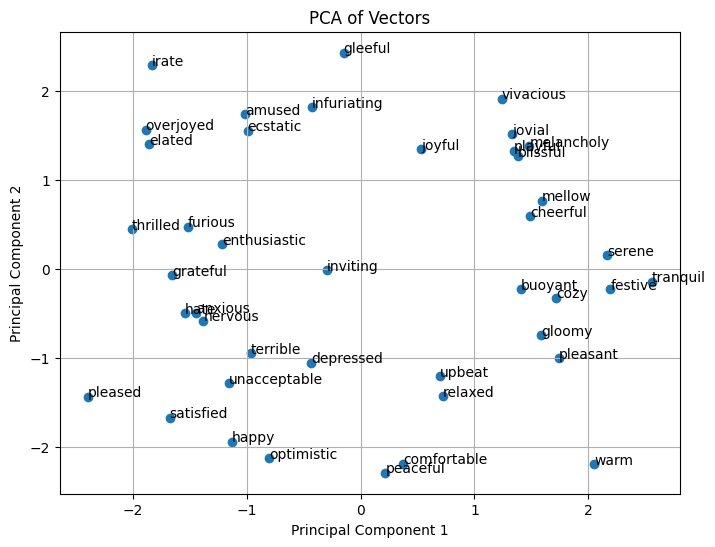

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

lexicon_embedded = {}

for word in lexicon.keys():
    lexicon_embedded[word] = adjectives_vectors[word]

# print(lexicon_embedded)

# Convert dictionary values to a NumPy array
X = np.array(list(lexicon_embedded.values()))

# Apply PCA (keep top 2 components for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Print explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Plot PCA components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], marker='o')

# Annotate points with dictionary keys
for i, key in enumerate(lexicon_embedded.keys()):
    plt.annotate(key, (X_pca[i, 0], X_pca[i, 1]))

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Vectors")
plt.grid()
plt.show()

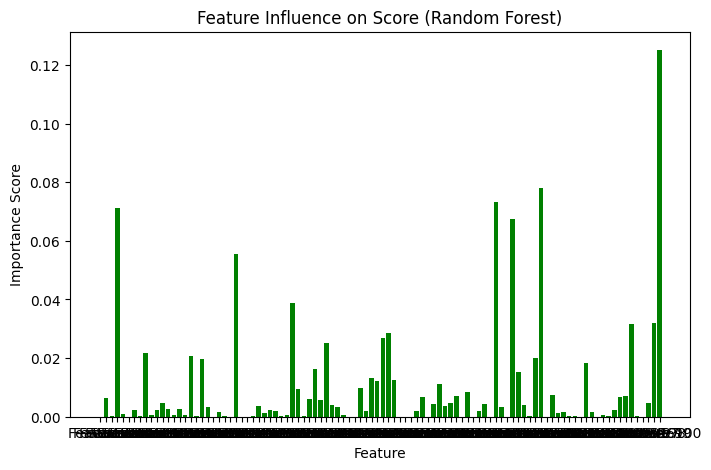

        Feature  Importance
99  Feature 100    0.125084
78   Feature 79    0.077901
70   Feature 71    0.073258
3     Feature 4    0.071192
73   Feature 74    0.067323
24   Feature 25    0.055477
34   Feature 35    0.038858
98   Feature 99    0.031996
94   Feature 95    0.031529
51   Feature 52    0.028717


In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import pandas as pd

vlexicon_embedded = {}

for word in lexicon.keys():
    lexicon_embedded[word] = adjectives_vectors[word]

X = np.array(list(lexicon_embedded.values()))
y = np.array([v[0] for v in lexicon.values()])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

# Get feature importances
importance_rf = rf.feature_importances_

feature_names = [f"Feature {i+1}" for i in range(X.shape[1])]

# Plot feature importance
plt.figure(figsize=(8, 5))
plt.bar(feature_names, importance_rf, color="green")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Influence on Score (Random Forest)")
plt.show()

# Print feature importance
feature_importance_rf = pd.DataFrame({"Feature": feature_names, "Importance": importance_rf})
print(feature_importance_rf.sort_values(by="Importance", ascending=False)[:10])


In [19]:
# Get indexes of features with importance > 0.04
important_feature_indexes = np.where(importance_rf > 0.04)[0]

# Print result
print("Indexes of most important features:", important_feature_indexes)

Indexes of most important features: [ 3 24 70 73 78 99]


In [20]:
lexicon_trained = {}
for key in adjectives_vectors:
    lexicon_trained[key] = [0, 0, 0, 0, 0, 0]

from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

    # Create a pipeline with StandardScaler and SVR, wrapped in MultiOutputRegressor
model = MultiOutputRegressor(make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0)))

x_train, y_train = [], []
for key in lexicon.keys():
    important_values = []
    for i in important_feature_indexes:
        important_values.append(adjectives_vectors[key][i])
    x_train.append(important_values)
    y_train.append([lexicon[key][0], 0])

x_train_np = np.array(x_train)
y_train_np = np.array(y_train)

    # Train the model
model.fit(x_train, y_train)

for key in adjectives_vectors:
    important_values = []
    for i in important_feature_indexes:
        important_values.append(adjectives_vectors[key][i])
    result = model.predict([important_values])
    lexicon_trained[key][0] = result[0][0]

for key, value in itertools.islice(lexicon_trained.items(), 10):
    print(key, ":", value)


abandoned : [0.5486681878355949, 0, 0, 0, 0, 0]
able : [0.2786191329553097, 0, 0, 0, 0, 0]
absolute : [0.4494940066117147, 0, 0, 0, 0, 0]
adorable : [0.3354374792276974, 0, 0, 0, 0, 0]
adventurous : [0.30175081906132595, 0, 0, 0, 0, 0]
academic : [0.10654594475349505, 0, 0, 0, 0, 0]
acceptable : [0.3548064934405259, 0, 0, 0, 0, 0]
acclaimed : [0.3922733839885639, 0, 0, 0, 0, 0]
accomplished : [0.1963125107184642, 0, 0, 0, 0, 0]
accurate : [0.547483080029996, 0, 0, 0, 0, 0]


## All together, from the very beginning, one by one: important steps:

In [2]:
# imports section
import numpy as np
import math
from numpy import dot
from numpy.linalg import norm
from gensim import corpora, models, similarities
import string

import gensim.downloader as api
from gensim.models import Word2Vec

import itertools

import json
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

In [18]:
# vectorization example:
# Define the lexicon with mood vectors
moods = {0: "Angry", 1: "Worried", 2: "Sad", 3: "Calm", 4: "Happy", 5: "Excited"}
moods_indeces = {y.lower(): x for x, y in moods.items()}

lexicon = {
    "anxious": [0.3, 0.9, 0.4, 0, 0, 0.1], "furious": [0.9, 0.3, 0.2, 0, 0, 0],
    "peaceful": [0, 0, 0, 1, 0.4, 0.2], "hate": [0.9, 0.3, 0.3, 0, 0, 0],
    "joyful": [0, 0, 0, 0.2, 0.9, 0.7], "unacceptable": [0.9, 0.6, 0.6, 0, 0, 0],
    "thrilled": [0, 0, 0, 0, 0.6, 1], "infuriating": [0.9, 0.8, 0.6, 0, 0, 0],
    "irate": [0.9, 0.2, 0.1, 0, 0, 0], "terrible": [0.9, 0.7, 0.7, 0, 0, 0],
    "nervous": [0.2, 0.8, 0.3, 0.1, 0, 0.2], "melancholy": [0.1, 0.4, 0.9, 0.2, 0, 0], 
    "depressed": [0.1, 0.1, 0.9, 0.2, 0, 0], "gloomy": [0.1, 0.1, 0.8, 0.3, 0, 0], 
    "serene": [0, 0, 0, 0.9, 0.8, 0.9], "elated": [0, 0, 0, 0.1, 0.8, 0.9],
    "ecstatic": [0, 0, 0, 0, 0.7, 1], "overjoyed": [0.1, 0.1, 0.1, 0.1, 1, 0.9], 
    "gleeful": [0.0, 0.1, 0.1, 0.1, 0.9, 0.8], "cheerful": [0.1, 0.1, 0.1, 0.1, 0.8, 0.5], 
    "optimistic": [0.0, 0.2, 0.1, 0.7, 0.8, 0.6], "buoyant": [0.1, 0.2, 0.1, 0.8, 0.7, 0.7], 
    "enthusiastic": [0.2, 0.3, 0.1, 0.6, 0.8, 0.9], "upbeat": [0.1, 0.2, 0.1, 0.7, 0.8, 0.7], 
    "festive": [0.0, 0.1, 0.1, 0.7, 0.8, 0.7], "playful": [0.0, 0.2, 0.1, 0.6, 0.7, 0.8], 
    "vivacious": [0.1, 0.2, 0.1, 0.6, 0.8, 0.7], "jovial": [0.0, 0.2, 0.1, 0.7, 0.8, 0.7], 
    "amused": [0.0, 0.2, 0.1, 0.6, 0.7, 0.7], "blissful": [0.0, 0.1, 0.1, 0.8, 0.9, 0.7], 
    "grateful": [0.0, 0.1, 0.1, 0.8, 0.9, 0.7], "tranquil": [0.0, 0.1, 0.1, 0.9, 0.8, 0.6], 
    "relaxed": [0.0, 0.1, 0.1, 0.9, 0.8, 0.6], "comfortable": [0.0, 0.1, 0.1, 0.8, 0.8, 0.6], 
    "cozy": [0.0, 0.1, 0.1, 0.8, 0.8, 0.6], "warm": [0.0, 0.1, 0.1, 0.8, 0.8, 0.6], 
    "inviting": [0.0, 0.1, 0.1, 0.8, 0.8, 0.6], "satisfied": [0.0, 0.1, 0.2, 0.6, 0.5, 0.3], 
    "pleasant": [0.0, 0.1, 0.1, 0.8, 0.8, 0.6], "pleased" : [0.0, 0.1, 0.1, 0.9, 0.8, 0.3], 
    "mellow": [0.0, 0.1, 0.1, 0.8, 0.8, 0.6], "happy": [0.0, 0.1, 0.1, 0.7, 1, 0.6],
    "overjoyed": [0, 0, 0, 0.6, 0.9, 0.8], "good": [0, 0, 0, 0.7, 0.9, 0.8],
    "pleased": [0, 0, 0, 0.6, 0.9, 0.8], "positive": [0, 0, 0, 0.7, 0.9, 0.8],
    "satisfied": [0, 0, 0.1, 0.9, 0.7, 0.2], "infuriating": [0.9, 0.8, 0.7, 0, 0, 0],
    "disappointed": [0.9, 0.8, 0.7, 0, 0, 0], "frustrated": [0.9, 0.8, 0.7, 0, 0, 0]
    }

In [4]:
# prepare data
# load corpus
corpus = api.load('glove-wiki-gigaword-100')
vector = corpus['computer']
# print(vector)

[==================================================] 100.0% 128.1/128.1MB downloaded


In [19]:
# read adjactives file
data = ''
with open('../resources/sets/english-adjectives.txt', 'r') as file:
    data = file.read().replace('\n', ',')

adjectives = data.split(',')
# print(adjectives[:20])


adjectives_vectors = {}

for adjective in adjectives:
    if adjective in corpus:
        adjectives_vectors[adjective] = corpus[adjective]

for key, value in itertools.islice(adjectives_vectors.items(), 2):
    print(key, ":", value)

abandoned : [ 0.43756    0.22949   -0.24099    0.42471   -0.25692    0.073755
 -0.096612   0.46294    0.85405    0.30859    0.35545    0.81983
  0.20312   -0.1225     0.17376   -0.62581    0.48522    0.23915
 -0.24558   -0.11948    0.69671    0.57527    0.65548   -0.029388
 -0.19702   -0.4308    -0.77335   -0.5166    -0.201      0.48815
  0.23728    0.31009   -0.25274   -0.042121  -0.19871   -0.17874
  0.019558  -0.42301    0.0743    -0.073421  -0.57583   -0.30048
  0.64496   -0.071048   0.52107    0.17243   -0.13616    0.97539
  0.23503   -0.28925   -0.072434   0.10553    0.24934    0.82306
  0.21013   -1.7977    -0.54545   -0.29966    1.0294     0.16126
  0.081623   0.53188    0.20484    0.36831    0.7118    -0.23808
  0.16678   -0.16994   -0.56703   -0.22874   -0.042396  -0.0065193
  0.01364   -0.2084    -0.35861   -0.055815   0.16845    0.46759
 -0.9905     0.35124   -0.070496   0.20322   -0.20443    0.75299
 -0.70367    0.19664    0.045248  -0.044681  -0.95952    0.31755
 -0.11741

In [20]:
# dimensionality reduction via random forest feature extraction, svm in cycle for every component

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

lexicon_embedded = {}

for word in lexicon.keys():
    lexicon_embedded[word] = adjectives_vectors[word]

lexicon_trained = {}
for key in adjectives_vectors:
    lexicon_trained[key] = [0, 0, 0, 0, 0, 0]

for i in range(6):
    X = np.array(list(lexicon_embedded.values()))
    y = np.array([v[i] for v in lexicon.values()])

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train a Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_scaled, y)

    # Get feature importances
    importance_rf = rf.feature_importances_
    # Get indexes of features with importance > 0.04
    important_feature_indexes = np.where(importance_rf > 0.04)[0]

    # Print result
    print(f"Indexes of most important features for {i}:", important_feature_indexes)

    # Create a pipeline with StandardScaler and SVR, wrapped in MultiOutputRegressor
    model = MultiOutputRegressor(make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0)))

    x_train, y_train = [], []
    for key in lexicon.keys():
        important_values = []
        for j in important_feature_indexes:
            important_values.append(adjectives_vectors[key][j])
        x_train.append(important_values)
        y_train.append([lexicon[key][i], 0])

    x_train_np = np.array(x_train)
    y_train_np = np.array(y_train)

    # Train the model
    model.fit(x_train, y_train)

    for key in adjectives_vectors:
        important_values = []
        for j in important_feature_indexes:
            important_values.append(adjectives_vectors[key][j])
        result = model.predict([important_values])
        lexicon_trained[key][i] = result[0][0]

for key, value in itertools.islice(lexicon_trained.items(), 10):
    print(key, ":", value)

# moods = {0: "Angry", 1: "Worried", 2: "Sad", 3: "Calm", 4: "Happy", 5: "Excited"}

Indexes of most important features for 0: [16 24 40 77 78 99]
Indexes of most important features for 1: [ 6 16 77 84]
Indexes of most important features for 2: [ 6 34 46 73 77]
Indexes of most important features for 3: [ 3  8 42 77]
Indexes of most important features for 4: [ 6  8 16 38 40 77]
Indexes of most important features for 5: [ 6  8 34 38 40 77 99]
abandoned : [0.48317394211671805, 0.17112353023552587, 0.3170236062501822, 0.357174666239504, 0.5321221216073753, 0.06895909276308693]
able : [0.39194696308307825, 0.09677284147476126, 0.010417803901659084, 0.3801111174431639, 0.8294606354706522, 0.406773028387275]
absolute : [0.18000612467629826, 0.197487753636132, 0.30367471503753485, 0.6152472387244333, 0.6865149337026736, 0.3993211963796905]
adorable : [0.12094977998067513, 0.11406396048258335, 0.13180686389304777, 0.10027479747635831, 0.8283754608843645, 0.6550937435177965]
adventurous : [-0.02519594125889668, 0.11876511881216567, 0.1896456594609101, 0.4969056865970055, 0.78954

In [25]:
import csv
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

import numpy as np
import matplotlib.pyplot as plt
import math
import random

import skfuzzy as fuzz
from skfuzzy import control as ctrl

from sklearn.metrics import mean_squared_error



validation_array = [
    [[0.2, 0.2, 0.9, 0.9, 0.2, 0.2], -5 ],
    [[0.9, 0.9, 0.2, 0.2, 0.2, 0.2], -8 ],
    [[0.9, 0.2, 0.9, 0.2, 0.2, 0.2], -7 ],
    [[0.2, 0.2, 0.2, 0.7, 0.7, 0.7], 7 ],
    [[0.2, 0.9, 0.2, 0.2, 0.9, 0.2], 7 ],
    [[0.1, 0.1, 0.1, 0.1, 0.7, 0.9], 9 ],
    [[0.2, 0.2, 0.2, 0.2, 0.9, 0.9], 9 ]
]

data_array = [row[0] for row in validation_array]
validation = [row[1] for row in validation_array]

moods_dict = {0: "angry", 1: "worried", 2: "sad", 3: "calm", 4: "happy", 5: "excited"}
moods_indeces = {y.lower(): x for x, y in moods_dict.items()}

moods = ["angry", "worried", "sad", "calm", "happy", "excited"]
mood_score = ["low", "medium", "high"]
predicator = ["or", "and"]
output_score_linguistic = ["high_negative", "negative", "neutral", "positive", "high_positive"]

# initial flrb population generation:
population_size = 100
rules_size = 9 # how many rules approximately in each rulebase

def get_random_rule():
    return random.choice(moods) + " " + random.choice(mood_score) + " and " + random.choice(moods) + " " + random.choice(mood_score) + " then " + random.choice(output_score_linguistic)


# initial_population = ["angry medium and worried medium and sad medium and calm medium and happy medium and excited medium then neutral"]

initial_rule = "angry medium and worried medium and sad medium and calm medium and happy medium and excited medium then neutral"
flrb_population = []

for i in range(population_size):
    fl_rb = []
    fl_rb.append(initial_rule)
    for j in range(rules_size):
        rule = get_random_rule()
        fl_rb.append(rule)
    flrb_population.append(fl_rb)

print(flrb_population[1])

emotion_intensity = np.arange(0, 11, 1)  # This could represent 0 to 10 scale of intensity
output_score = np.arange(-10, 11, 1)     # This could represent a score from -10 (Highly Negative) to 10 (Highly Positive)

antecedents = []

# Create the fuzzy variables for inputs and output
for i in range(len(moods_dict)):
    antecedents.append(ctrl.Antecedent(emotion_intensity, moods_dict[i]))

output = ctrl.Consequent(output_score, 'output')

# Define fuzzy sets and membership functions for each variable
for item in antecedents:
    item.automf(names=['low', 'medium', 'high'])


output['high_negative'] = fuzz.trimf(output_score, [-10, -7, -4])
output['negative'] = fuzz.trimf(output_score, [-7, -4, -1])
output['neutral'] = fuzz.trimf(output_score, [-3, 0, 3])
output['positive'] = fuzz.trimf(output_score, [1, 4, 7])
output['high_positive'] = fuzz.trimf(output_score, [4, 7, 10])

def calculate_fuzzy(data_points, rulebase):
    rules = []
    for rule in rulebase:
        predicates = rule.lower().split(' ')
        ant_predicates = antecedents[moods_indeces[predicates[0]]][predicates[1]]
        i = 2
        while i < len(predicates) - 2:
            if predicates[i] == 'or':
                ant_predicates = ant_predicates | antecedents[moods_indeces[predicates[i+1]]][predicates[i+2]]
            else:
                ant_predicates = ant_predicates & antecedents[moods_indeces[predicates[i+1]]][predicates[i+2]]
            i += 3
        rules.append(ctrl.Rule(ant_predicates, output[predicates[len(predicates) - 1]]))

    # Create the control system and simulation
    emotion_ctrl = ctrl.ControlSystem(rules)
    emotion_sim = ctrl.ControlSystemSimulation(emotion_ctrl)
    output_vector = []

    # Pass inputs to the ControlSystem using Antecedent labels with Pythonic API
    for data_point in data_points:
        for i,aggregated_mood in enumerate(data_point):
            emotion_sim.input[moods_dict[i]] = (aggregated_mood) * 10
        emotion_sim.compute()
        output_vector.append(emotion_sim.output['output'])

    # Crunch the numbers
    
    # output.view(sim=emotion_sim)
    return output_vector

def generate_new_population(progenitors, number_successors=90, mutation_rate=0.0):
    new_population = list(progenitors)
    for i in range(number_successors):
        prog = random.sample(range(0, len(progenitors)), 2)
        fl_rb = []
        for j in range(rules_size):
            if j != 0 and np.random.uniform(0, 1) < mutation_rate:
                rule = get_random_rule()
            else:
                rule = progenitors[random.choice(prog)][j]
            fl_rb.append(rule)
        new_population.append(fl_rb)

    return new_population


list_mse = []
steps = 50
mutation_steps = [5,6,10,11,15,16,20,21,25,26,30,31,35,36,40,41,45,46,50,51,55,56,90,91]
for i in range(steps):
    mse = []
    results = []
    for rulebase in flrb_population:
        res = calculate_fuzzy(data_array, rulebase)
        results.append(res)
        mse.append(mean_squared_error(validation, res))
    prog = []
    smallest_10_indices = sorted(range(len(mse)), key=lambda i: mse[i])[:10]
    for j in range(len(flrb_population)):
        if(j in smallest_10_indices):
            prog.append(flrb_population[j])
    
    if i in mutation_steps:
        new_population = generate_new_population(prog, mutation_rate=0.1)
    else:   
        new_population = generate_new_population(prog, mutation_rate=0.001)
    if i % 5 == 0:
        print(f'step: {i}, average mse: {sum(mse) / len(mse)}')
    list_mse.append(sum(mse) / len(mse))
    flrb_population = list(new_population)
    i += 1

min_mse = mse.index(min(mse))
flrb_min = flrb_population[min_mse]
print(f'minimal mse: {min(mse)}')
print(flrb_min)

with open("../resources/sets/outputs.json", "r") as f:
    data = json.load(f)

# Update only the specific field
data["nlp-sentiment"]["minimal-frlb"] = flrb_min

# Save it back without overwriting other parts
with open("../resources/sets/outputs.json", "w") as f:
    json.dump(data, f, indent=4)

['angry medium and worried medium and sad medium and calm medium and happy medium and excited medium then neutral', 'excited medium and sad high then negative', 'angry medium and happy medium then high_positive', 'excited low and worried high then positive', 'happy medium and sad medium then high_positive', 'excited low and happy high then negative', 'worried low and sad low then neutral', 'excited medium and worried low then neutral', 'happy medium and angry high then neutral', 'excited high and worried low then neutral']
step: 0, average mse: 65.26211852211685
step: 5, average mse: 11.207275304340765
step: 10, average mse: 9.65681335902903
step: 15, average mse: 8.41348750543324
step: 20, average mse: 8.216866493142067
step: 25, average mse: 8.145135781941688
step: 30, average mse: 8.266795775290513
step: 35, average mse: 8.299578038823812
step: 40, average mse: 9.014984186471803
step: 45, average mse: 8.223562721185898
minimal mse: 8.14513578194168
['angry medium and worried medium 

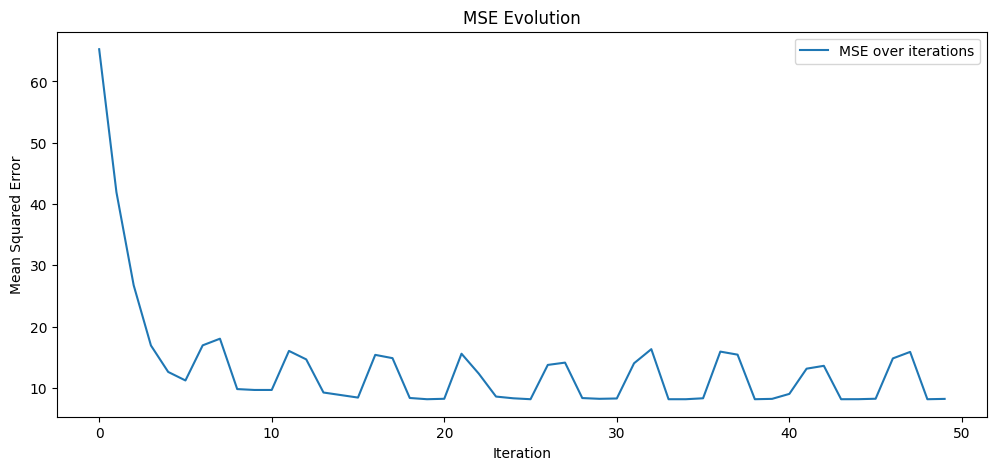

In [26]:
if list_mse:
    plt.figure(figsize=(12, 5))
    plt.plot(list_mse, label='MSE over iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Squared Error')
    plt.title('MSE Evolution')
    plt.legend()
    plt.show()

In [ ]:
# you may run this only once
import nltk

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\first\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\first\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\first\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\first\AppData\Roaming\nltk_data...


True

In [24]:
with open("../resources/sets/outputs.json", "r") as f:
    data = json.load(f)

flrb = data["nlp-sentiment"]["minimal-frlb"]

texts = [
    "I absolutely hate everything about this situation, and it makes me furious that such incompetence could exist in the world!",
    "This is completely unacceptable and infuriating, and I cannot believe that such a terrible outcome could happen despite all the efforts put in.",
    "I am very disappointed and frustrated with this situation, as it seems like everything that could go wrong has gone wrong, and it feels like no one cares about the consequences.",
    "I'm not happy with the outcome, as it falls far short of what was promised and expected, leaving me feeling quite let down and disillusioned.",
    "I'm somewhat satisfied with the results, as they meet the minimum expectations, but there are still several aspects that could be enhanced to achieve a truly satisfactory experience.",
    "I'm quite pleased with how things turned out overall, as most of my expectations were met, and there were some positive surprises along the way.",
    "This is very good, I'm happy with it, and I appreciate the effort that went into making this a successful outcome with only a few minor issues.",
    "I'm absolutely thrilled and overjoyed with everything, as this has exceeded all my expectations and has brought a tremendous amount of satisfaction and joy to my experience!"
]

for text in texts:
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()

    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(text)
    words = [word for word in words if word.isalpha()]
    # words = [word for word in words ]
    # words = [lemmatizer.lemmatize(word) for word in words]
    # words = [stemmer.stem(word) for word in words]

    data_points = []
    for i in range(len(moods_dict)):
        data_points.append(0)
    
    used_words = 0

    for word in words:
        if word in lexicon_trained:
            used_words += 1
            for i in range(len(moods_dict)):
                data_points[i] += lexicon_trained[word][i]
    
    for i in range(len(moods_dict)):
        data_points[i] = data_points[i] / used_words

    res = calculate_fuzzy([data_points], flrb)
    print(f"Text: {text}")
    print(f"Data points: {data_points}")
    print(f"Fuzzy Logic Result: {res[0]}")

print(lexicon_trained['thrilled'])

Text: i absolutely hate everything about this situation and it makes me furious that such incompetence could exist in the world
Data points: [0.5690162811439089, 0.18605534611385083, 0.245504677308239, 0.15205563370180117, 0.44528655790115507, 0.34475959790546723]
Fuzzy Logic Result: -3.5296888972656193
Text: this is completely unacceptable and infuriating and i cannot believe that such a terrible outcome could happen despite all the efforts put in
Data points: [0.5048478641735662, 0.28880202597923116, 0.3983123748953446, 0.18460881299029672, 0.4380979965949235, 0.35784894147500257]
Fuzzy Logic Result: -3.1328256551499916
Text: i am very disappointed and frustrated with this situation as it seems like everything that could go wrong has gone wrong and it feels like no one cares about the consequences
Data points: [0.5984103785764708, 0.4205567266901416, 0.37387744011279783, 0.06877052966647325, 0.38757608311979075, 0.25419709638275295]
Fuzzy Logic Result: -4.065542672713899
Text: im not

In [39]:
arr = [2, 1, 5, 10, 8]
print(sorted(arr))

[1, 2, 5, 8, 10]


**Mean Squared Error**

FLR : $(x_i) -> y^{(f)}_i$

Test Data: $(x_i) -> y_i$

$$\sum_i (y_i - y^{(f)}_i)^2 $$


**Genetic Algorithm Approach**

1. Generate initial population: 100 FLRBs, with around 5 fuzzy rules each 

THink about how to initialize linguistic variables for each FLRB!

2. Every step, use fitness function (mse) -> select 10 flrbs, use them to create 50 new flrbs, 40 more generate with random generator, repeat 

3. Introduce mutations 





**TODO**:

1. cross-validation, fine tuning
2. Find political data, find more words!
3. fuzzy logic rule generation! (may be via evolut. algorithms)
4. apply fl rules
5. results!

What we did!

1. Lemmatization, stemming of text. Tf idf https://habr.com/ru/companies/otus/articles/755772/

2. We tried Principal compoenent analysis, no success: https://www.geeksforgeeks.org/principal-component-analysis-pca/

3. Random forest machine learning algorithm, random forest feature extraction. https://www.geeksforgeeks.org/feature-selection-using-random-forest/

4. Support vector regression for principal compoinents. https://www.geeksforgeeks.org/support-vector-regression-svr-using-linear-and-non-linear-kernels-in-scikit-learn/

5. Genetic algorithm for generating fuzzy logic rule sets. (article sent)

6. Applying fuzzy logic rule base to our data points

7. Cross validation. https://www.geeksforgeeks.org/cross-validation-machine-learning/